In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = '/content/drive/Shared drives/650 final project'
os.chdir(path)
# os.listdir(path)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import cv2                  
import os 

from sklearn.preprocessing import OneHotEncoder
from google.colab.patches import cv2_imshow
from keras.models import load_model
from keras.applications.vgg16 import VGG16

## image recognition

In [ ]:
# load the labels
r = np.load("vege_image_classification/XandZ.npz") 
Z = r["arr_1"] 
ohe = OneHotEncoder()
ohe.fit(Z.reshape(-1,1))
label_array = ohe.categories_[0]  # the list of labels (text)

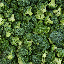

In [ ]:
# Read in the image
DIR = 'vege_image_classification/input image'  # upload the image into this folder
img_path = os.listdir(DIR)[0] 
IMG_SIZE = 64

path = os.path.join(DIR,img_path)
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))  # resize the image
cv2_imshow(img)  # show the resized image
# print('Resized Dimensions : ',img.shape)

X=[]
X.append(np.array(img))

# normalized the data
X = np.array(X)  # convert X from list to np.array
X = X.astype('float32')/255  # normalized the data to 0-1

In [ ]:
# predict the label
model = load_model('vege_image_classification/vgg16_conv_tuning_last2conv_modelsave.h5')
model.load_weights('vege_image_classification/vgg16_vege_conv_tuning_2.hdf5')
Y = model.predict(X)
predicted_label = label_array[np.argmax(Y)]
print(predicted_label)

broccoli


## retrieve recipe with metapy

In [ ]:
!pip install metapy
import metapy

# build the inverted index with metapy
inv_idx = metapy.index.make_inverted_index('recipe_ir-config.toml')
ranker = metapy.index.OkapiBM25(k1 = 1.2, b = 0.5, k3 = 500)

     |████████████████████████████████| 14.3MB 301kB/s 


In [ ]:
# retrieve recipes
line = input('input your query:') # interact with users in console
num_results = 10 # top10 results

query = metapy.index.Document()
query.content(line.strip())
results = ranker.score(inv_idx, query, num_results)

print("Query: ", query.content())
print("Retrieved Results")
for num, (d_id, _) in enumerate(results):  # d_id: doc id, _: the score
    content = inv_idx.metadata(d_id).get('content')
    print(str(num + 1), content)

input your query:How can I cook Lettuce?
Query:  How can I cook Lettuce?
Retrieved Results
1 "1 1/2 tablespoons vegetable oil 2 spring onions , minced 4 cloves garlic , minced , divided 1 small head romaine lettuce , leaves separated 2 teaspoons oyster sauce 1 teaspoon salt  | Heat oil in a wok or large skillet over high heat ; add green onions and 1/2 of the garlic . Cook and stir until fragrant , about 1 minute . Add romaine lettuce and oyster sauce ; cook and quickly stir until lettuce turns bright green , 1 to 2 minutes . Turn heat to medium . Mix remaining garlic and salt into lettuce mixture and stir . \"
2 "1 large head cauliflower 4 tablespoons vegetable oil 1/2 teaspoon ground turmeric 1 small onion , minced 2 tomatoes , pureed 1 teaspoon garlic powder 3 teaspoons garam masala (optional) salt to taste 1/2 head lettuce  | Preheat the oven to 350 degrees F (175 degrees C) . Cut off most of the cauliflower's stem and place the whole head in a baking dish . Heat two tablespoons of

## retrive recipe without metapy

In [ ]:
!pip install rank_bm25

In [ ]:
# stop words
sw = pd.read_fwf('lemur-stopwords.txt')
sw.columns = ['stop_word']
sw_list = list(sw.stop_word)

In [ ]:
recipe_df = pd.read_csv('recipe.csv')
recipe_df.tail()

,recipe_text,recipe_id
1405,1 cup lukewarm water 1/4 cup whole wheat flour...,1406
1406,"1 clove garlic , minced 1/2 cup mayonnaise 2 t...",1407
1407,"16 cups plain yogurt 1 teaspoon salt , or to t...",1408
1408,1/2 cup water 1 teaspoon cornstarch 1/3 cup le...,1409
1409,"4 cloves garlic , peeled 1/4 cup vegetable oil...",1410


In [ ]:
from rank_bm25 import BM25Okapi

test_message_id = []
test_response_id = []

tokenized_corpus = [
    [word for word in document.lower().split() if word not in sw_list]
    for document in recipe_df.recipe_text
]

bm25 = BM25Okapi(tokenized_corpus)
query = input('input your query: ')
tokenized_query = [word for word in query.lower().split()] #  if word not in sw_list
doc_scores = bm25.get_scores(tokenized_query)   # a list of bm25 scores for each docs
recipe_temp = recipe_df.copy()
recipe_temp['query_score'] = doc_scores
print(recipe_temp.sort_values(by='query_score',ascending=False)[:10]['recipe_text'])

input your query: How can I cook Lettuce?
414     1 tablespoon vegetable oil 2 cloves garlic , m...
127     2 teaspoons olive oil 1 1/2 pounds ground beef...
844     1 tablespoon olive oil 6 ounces pancetta or sa...
502     2 tablespoons olive oil 1 shallot , diced 1 cu...
683     1 (16 ounce) package firm tofu 3 tablespoons v...
118     2 1/2 pounds bone-in chicken pieces 2 tablespo...
939     1 (12 ounce) package penne pasta 2 tablespoons...
931     1 pound linguine pasta 1/2 cup butter 2 cups h...
644     3 tablespoons butter 1 medium onion , chopped ...
1404    8 cups water 1 cup large brown lentils , rinse...
Name: recipe_text, dtype: object
